## Vehicle Detection Projection Goals (P5)
---
The primary goals of this project are detailed below:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Apply any color transformations, binned color features, histograms of color to HOG feature vector. 
* Normalize features and randomize selection of data for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in individual images.
* Execute image processing pipeline on a video stream using the sample videos provided in the previous Advanced Lane Lines project and create a heat map of recurring detections in each frame to reject outliers while following detected vehicles.
* Estimate bounding boxes for vehicles detected.
---

## Step 1 Import all Essential Libraries

In [75]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Step 2 - Review Techniques and Common Methods

In [94]:
# Function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Function to search for template matches and return a list of bounding boxes
def template_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

# Function to explore color spaces in  3D
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Define a function to return HOG features and visualization
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, 
#                                   pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), 
#                                   transform_sqrt=False, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, 
#                        pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), 
#                        transform_sqrt=False, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Normalize data
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))
#             hog_features = np.ravel(hog_features)        
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         # Append the new feature vector to the features list
#         features.append(hog_features)
#     # Return list of feature vectors
#     return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Train Classifer based on Car and Non Car features
def train_classifier(car_features, notcar_features):
    # Define a labels vector based on features lists
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Use a linear SVC (support vector classifier)
    svc = LinearSVC()
    
    # Train the SVC
    svc.fit(X_train, y_train)
    return svc, X_train, X_test, y_train, y_test

def test_classifier(svc):
    return round(svc.score(X_test, y_test), 4)

def test_prediction(X_test, y_test, n_predict):
    return svc.predict(X_test[0:n_predict]), y_test[0:n_predict]


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Step 3 - Load Cars and Non Cars Images - Small Set

Cars List Size: 8792
Non Cars List Size: 8968


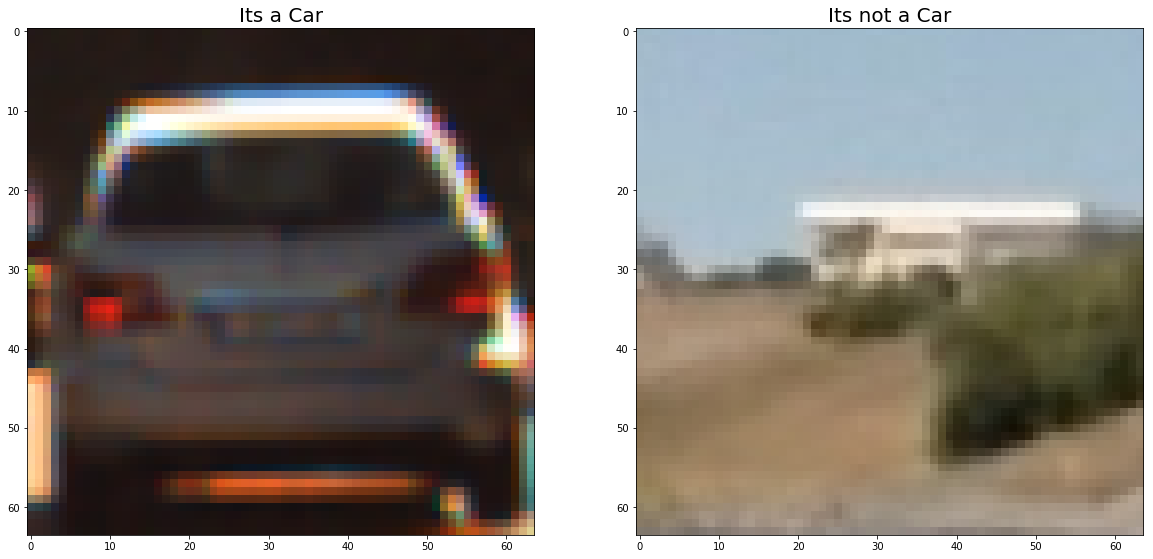

In [95]:
# Read in cars and notcars
images = glob.glob('./vehicles/**/*.png')
cars = []
notcars = []
for image in images:
    cars.append(image)
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

        
images = glob.glob('./non-vehicles/**/*.png')
for image in images:
    notcars.append(image)
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

print("Cars List Size:", len(cars))
print("Non Cars List Size:", len(notcars))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()

sample_car = cv2.imread(cars[np.random.randint(0,len(cars))])
sample_car = cv2.cvtColor(sample_car, cv2.COLOR_BGR2RGB)
sample_noncar = cv2.imread(notcars[np.random.randint(0,len(notcars))])
sample_noncar = cv2.cvtColor(sample_noncar, cv2.COLOR_BGR2RGB)

ax1.imshow(sample_car, cmap='gray')
ax1.set_title('Its a Car', fontsize=20)
ax2.imshow(sample_noncar, cmap='gray')
ax2.set_title('Its not a Car', fontsize=20)

## Step 4 - Test Feature Extractions

### HOG Extraction Test

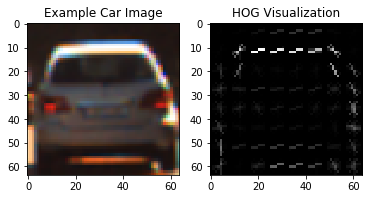

In [96]:
gray_car = cv2.cvtColor(sample_car, cv2.COLOR_RGB2GRAY)
gray_noncar = cv2.cvtColor(sample_noncar, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

#Call HOG Extract
hog_car_features, hog_car_image = get_hog_features(gray_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_noncar_features, hog_noncar_image = get_hog_features(gray_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(sample_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_car_image, cmap='gray')
plt.title('HOG Visualization')

### Extract Features from all Cars and Non Cars

In [97]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print("Feature Extraction execution in: ",round(t2-t, 2)," seconds")

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
print('Training Set Size:', len(X_train))
print('Test Set Size:', len(X_test))

Feature Extraction execution in:  53.66  seconds
Training Set Size: 14208
Test Set Size: 3552


### Train a classifier using reusable method to train_classifier()

In [98]:
#Train SVC classifier - The train classifier decides all the details of training and test sets
svc,X_train, X_test, y_train, y_test = train_classifier(car_features, notcar_features)

# Find Accuracy score
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Test prediction time for a sample
t=time.time()
n_predict = 10
print('Prediction of SVC: ', svc.predict(X_test[0:n_predict]))
print('For ', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print('It took',round(t2-t, 5), ' seconds to predict', n_predict,' labels with SVC')

Test Accuracy of SVC =  0.9733
Prediction of SVC:  [ 1.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
For  10 labels:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
It took 0.0019  seconds to predict 10  labels with SVC


In [99]:
#Finding cars test
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

Number of bound boxes identified:  78


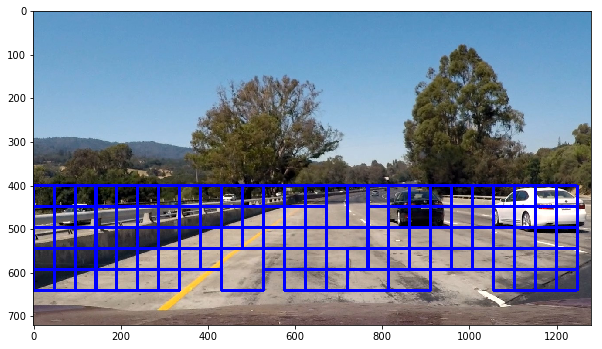

In [100]:
sample_test_image = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(sample_test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print('Number of bound boxes identified: ', len(rectangles))
rectangles_in_image = draw_boxes(sample_test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(rectangles_in_image)

Number of boxes:  78


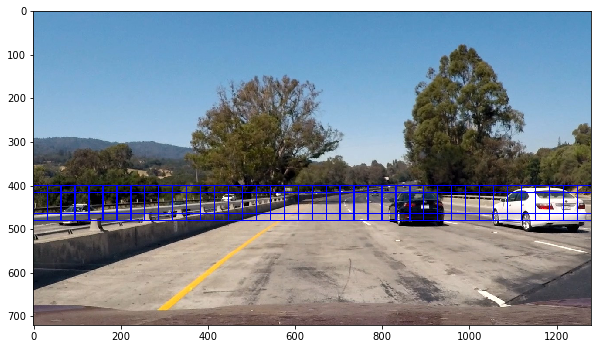

In [101]:
find_all_rects = []

ystart = 400
ystop = 464
scale = 1.0
find_all_rects.append(find_cars(sample_test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
find_all_rects.append(find_cars(sample_test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in find_all_rects for item in sublist] 
all_rectangles_image = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(all_rectangles_image)
print('Number of boxes: ', len(rectangles))

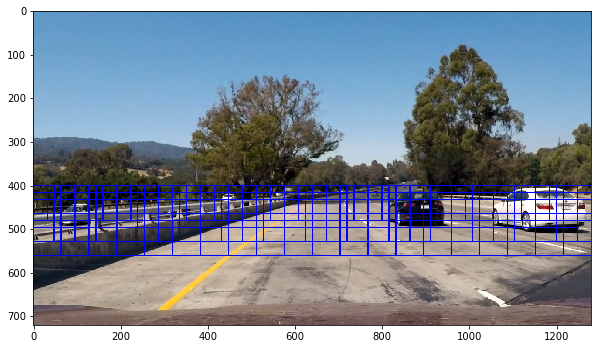

In [102]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

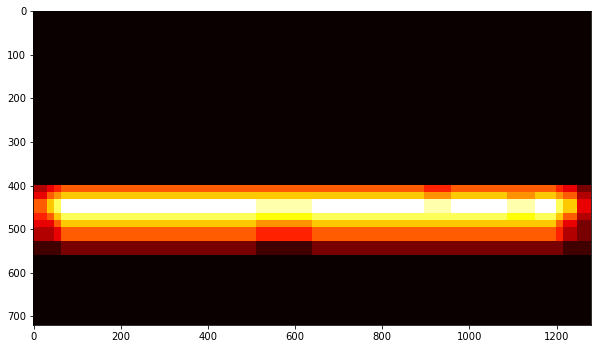

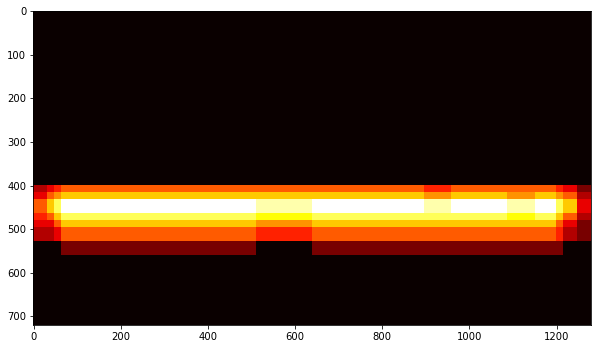

In [107]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
labels = label(heatmap_img)
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

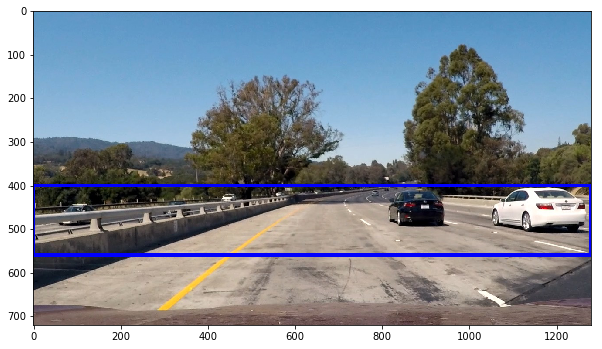

In [108]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [112]:
def pipeline(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    #draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

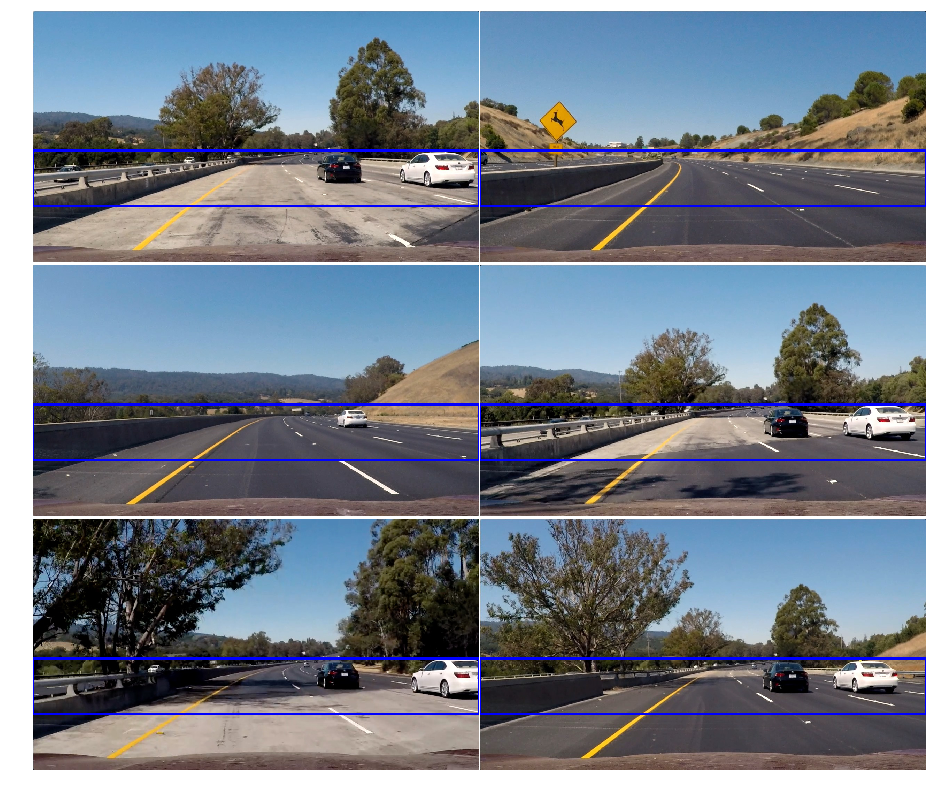

In [113]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(pipeline(mpimg.imread(im)))
    axs[i].axis('off')